<a href="https://colab.research.google.com/github/mario-dg/KI-Gruppe-03/blob/eda-jonathan/AI_COV_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA
- "A worldwide epidemiological database for COVID-19 at finegrained spatial resolution" - 2022, Guidotti
- [data origin](https://covid19datahub.io/articles/data.html)
- [docs](https://covid19datahub.io/articles/docs.html)

## TODO/NOTES
- maybe look into the rows where administrative_area_level_2 and administrative_area_level_3 are null because they might have a meaning (nation wide restrictions or something like that)
- outlier detection
- plot some cool looking maps
- time series analysis

## importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install geopandas
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
import itertools
from datetime import datetime, timedelta

In [3]:
#df = pd.read_csv("DEU.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU.csv")
#df = pd.read_csv("https://storage.covid19datahub.io/country/DEU.csv")
# df with only epidemiological variables
epi_features = list(df.columns[2:12])
epi_features.append('population')
epi_df = df[epi_features]


# df with only policy measures
policy_features = list(df.columns[12:26])
policy_df = df[policy_features]

<ipython-input-3-5fd016b09700>:2: DtypeWarning: Columns (33,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU.csv")


## functions

In [4]:
# bundesland
def get_df_by_fed_state(fed_state, df):
  return df[df['administrative_area_level_2']==fed_state]
  
# landkreis
def get_df_by_district(district, df):
  return df[df['administrative_area_level_3']==district]

def to_date_df(df):
  return df.set_index('date')

def get_df_row_at_date(df, target_date):
  if isinstance(target_date, str):
    target_date = pd.to_datetime(target_date)

  # Find the closest date in the index
  closest_date = df.index[df.index.get_loc(target_date, method='nearest')]

  # Retrieve the row at the closest date index
  return df.loc[closest_date]

## data preprocessing

In [5]:
def drop_keys(df):
  cols = ['key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm']
  df = df.drop(cols ,axis=1)
  return df
def drop_indices(df):
  cols = ['government_response_index', 'stringency_index', 'containment_health_index', 'economic_support_index']
  df = df.drop(cols ,axis=1)
  return df
  
#drop key values (for now)
processed_df = drop_keys(df)

#drop indices (for now)
processed_df = drop_indices(processed_df)

#drop unimportant columns
processed_df = processed_df.drop(['hosp', 'vent', 'icu', 'tests' , 'iso_alpha_3', 'iso_alpha_2', 'iso_currency', 'iso_numeric'],axis=1)
epi_features = [x for x in epi_features if x != 'hosp']
epi_features = [x for x in epi_features if x != 'vent']
epi_features = [x for x in epi_features if x != 'icu']
epi_features = [x for x in epi_features if x != 'tests']

#drop 4%~ of columns where almost all policies values are empty
processed_df = processed_df.dropna(subset=['workplace_closing'])

# change categorical values from to int
for col in policy_df:
  processed_df[col] = processed_df[col].astype(int)

# change date string to datetime obj
processed_df['date'] = pd.to_datetime(processed_df['date'])

# set date threshold
date_threshold = '2020-12-27'

# convert certain values from NaN to 0
processed_df.loc[processed_df['date'] < date_threshold, 'vaccines'] = 0
processed_df.loc[processed_df['date'] < date_threshold, 'people_vaccinated'] = 0
processed_df.loc[processed_df['date'] < date_threshold, 'people_fully_vaccinated'] = 0

# fill the rest of the nan values
processed_df['vaccines'].fillna(method='ffill', inplace = True)
processed_df['people_vaccinated'].fillna(method='ffill', inplace = True)
processed_df['people_fully_vaccinated'].fillna(method='ffill', inplace = True)
processed_df['recovered'].fillna(method='ffill', inplace = True)
processed_df['deaths'].fillna(method='ffill', inplace = True)
processed_df['confirmed'].fillna(method='ffill', inplace = True)
# unnecessarily computationally expensive (but it works)
#for id in unique_ids:
#  processed_df.loc[processed_df['id'] == id, 'vaccines'] = processed_df.loc[processed_df['id'] == id, 'vaccines'].fillna(method='ffill')
#  processed_df.loc[processed_df['id'] == id, 'people_vaccinated'] = processed_df.loc[processed_df['id'] == id, 'people_vaccinated'].fillna(method='ffill')
#  processed_df.loc[processed_df['id'] == id, 'people_fully_vaccinated'] = processed_df.loc[processed_df['id'] == id, 'people_fully_vaccinated'].fillna(method='ffill')


# drop nation/federation wide columns
processed_df = processed_df.dropna(subset=['administrative_area_level_3'])

# create arr of all districts
districts = processed_df['administrative_area_level_3'].unique()

<ipython-input-5-9fa603701999>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[col] = processed_df[col].astype(int)


## general inspection

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# Count by id
counts = df['id'].value_counts()
print('number of unique ids: '+str(len(counts)))

number of unique ids: 429


In [ ]:
# Count by id
counts = df['longitude'].value_counts()
print('number of unique longitude values: '+str(len(counts)))

number of unique longitude values: 416


In [ ]:
# Count by administrative_area_level_3
counts = df['administrative_area_level_3'].value_counts()
print('number of unique administrative_area_levels_3: '+str(len(counts)))

number of unique administrative_area_levels_3: 412


In [ ]:
# Count the number of unique values in each column
unique_counts = df.nunique()

# Print the counts
print(unique_counts)

In [ ]:
# Filter for columns with object data type
obj_cols = df.select_dtypes(include=['object']).columns
df_obj = df[obj_cols]
# Filter for columns with float data type
float_cols = df.select_dtypes(include=['float64']).columns
df_float = df[float_cols]

## missing values

In [ ]:
def plot_missing_values(df):
  # Calculate the count of missing values in each column
  missing_counts = df.isna().sum()
  missing_percentages = (missing_counts / len(df)) * 100

  # Drop columns with no missing values
  missing_counts = missing_counts[missing_counts != 0]
  missing_percentages = missing_percentages[missing_percentages != 0]

  # Sort columns by missing values in descending order
  sorted_columns = missing_counts.sort_values(ascending=False).index

  # Plot the missing value counts and percentages as a horizontal bar chart
  plt.figure(figsize=(10,8))
  plt.barh(sorted_columns, missing_counts[sorted_columns])
  for i, v in enumerate(missing_counts[sorted_columns]):
      plt.text(v, i,f" ({missing_percentages[sorted_columns][i]:.2f}%)", color='blue', fontweight='bold')
  plt.xlabel('Count of missing values')
  plt.ylabel('Columns')
  plt.title('Missing Value Counts in DataFrame')
  plt.show()

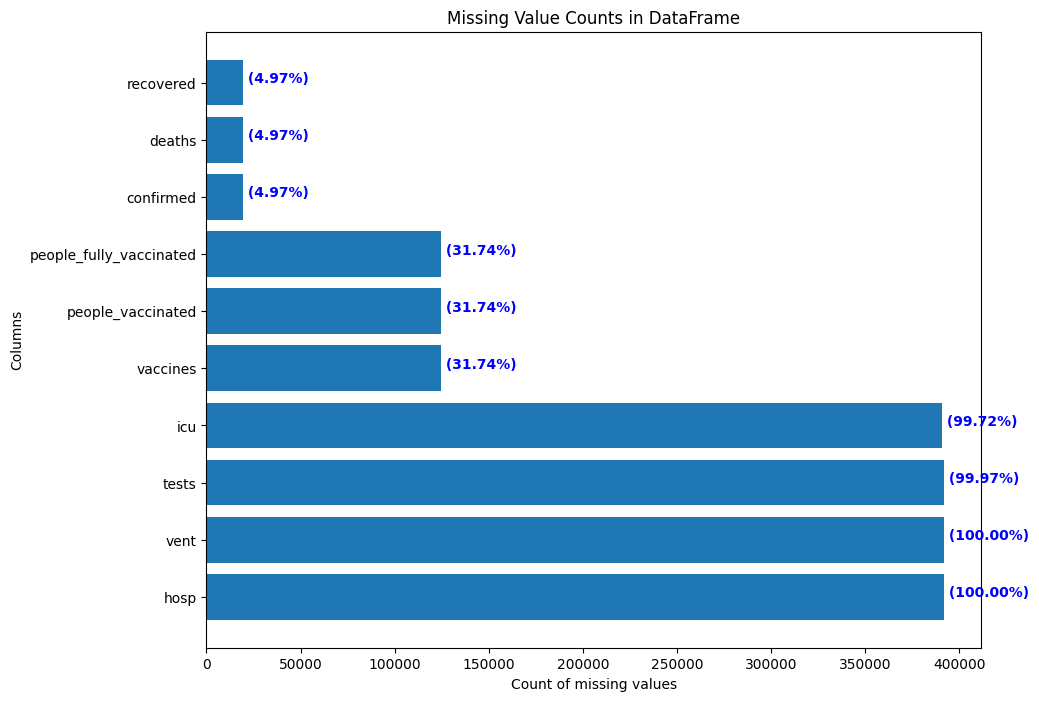

In [ ]:
plot_missing_values(epi_df)

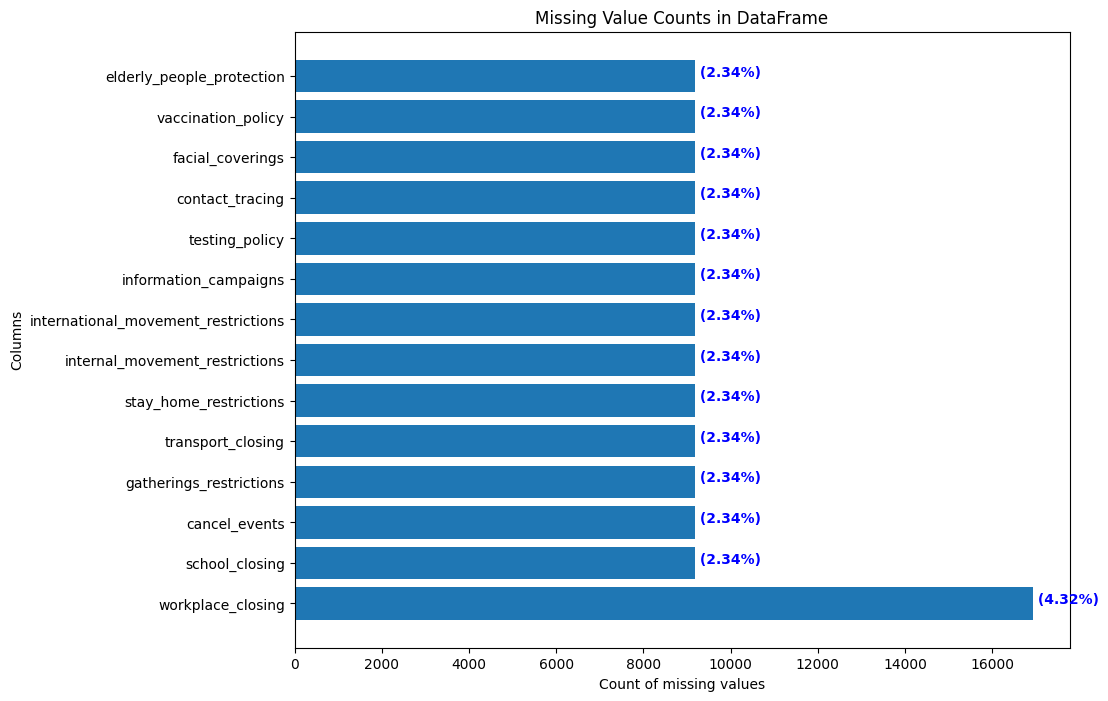

In [ ]:
plot_missing_values(df[policy_features])

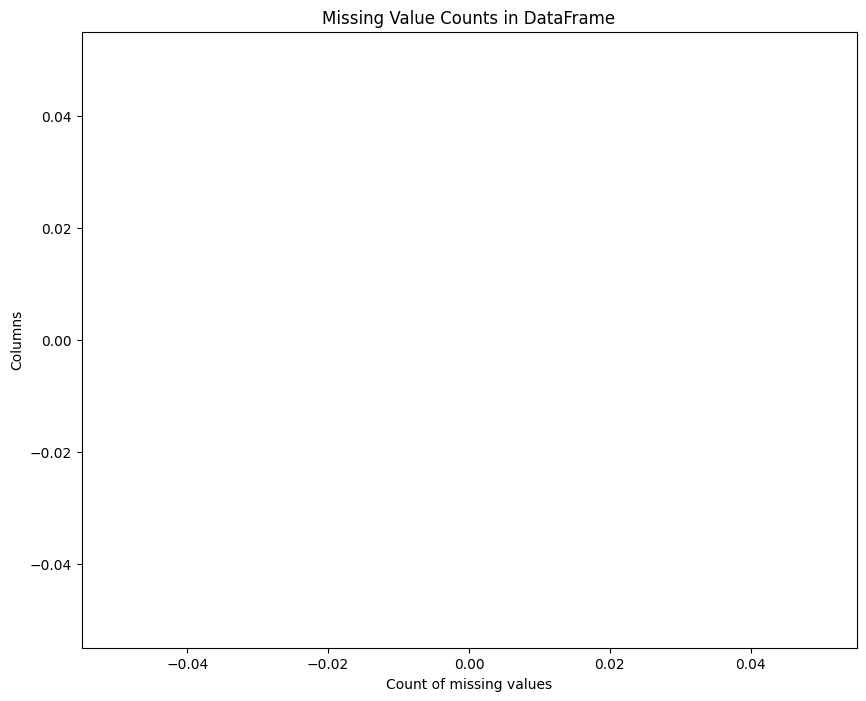

In [ ]:
plot_missing_values(processed_df)

### handle missing data (TODO FOR SOME COLUMNS)

administrative_area_level_3 and administrative_area_level_2 are only empty when the restrictions were on a level above, because then the federal state or district doesn't matter

In [ ]:
nan_rows = processed_df[processed_df['administrative_area_level']==3]
nan_rows = nan_rows[nan_rows[['administrative_area_level_3']].isna().any(axis=1)]
#nan_rows = processed_df[processed_df[['administrative_area_level_3']].isna().any(axis=1)]
nan_rows = nan_rows[['administrative_area_level_3','administrative_area_level_2','administrative_area_level','id','date']]

In [ ]:
nan_rows

,administrative_area_level_3,administrative_area_level_2,administrative_area_level,id,date


## data distribution

In [ ]:
def plot_distribution(df):
  # Plot the distribution of each column
  for col in df.columns:
      plt.figure(figsize=(10,8))
      plt.hist(df[col].dropna(), bins=30)
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')
      plt.show()

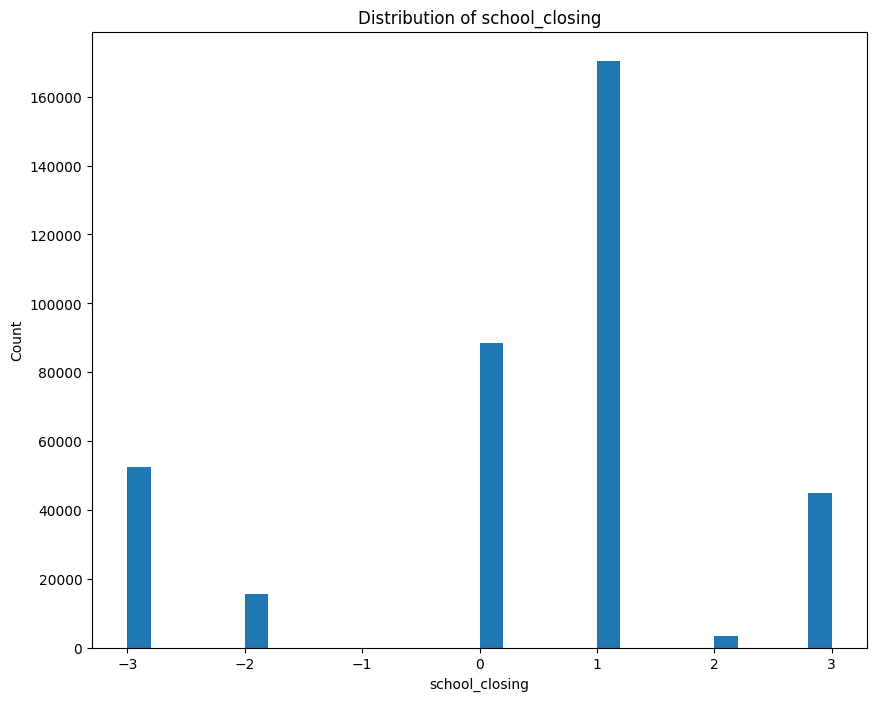

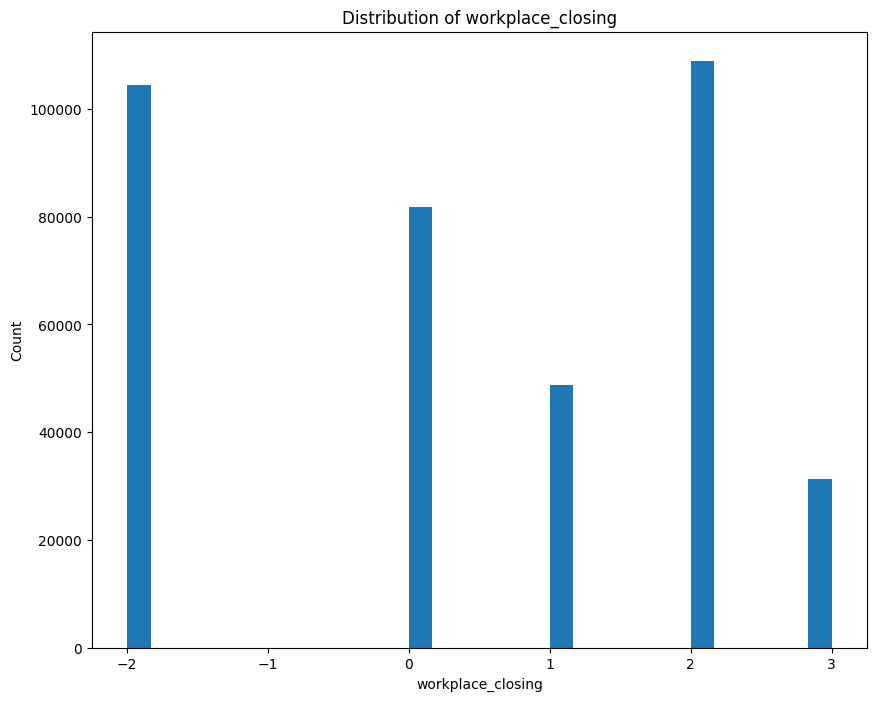

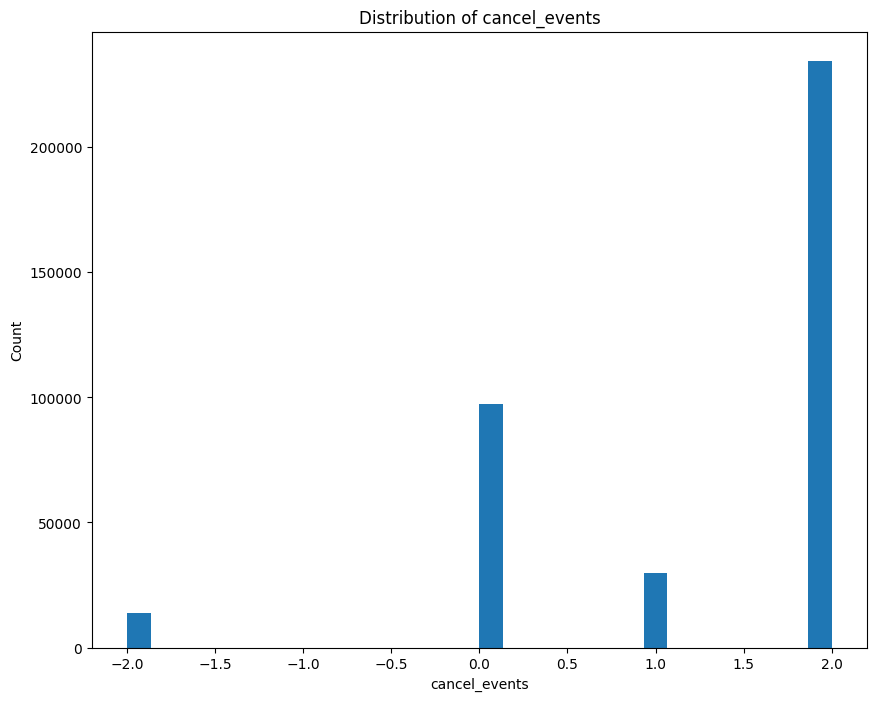

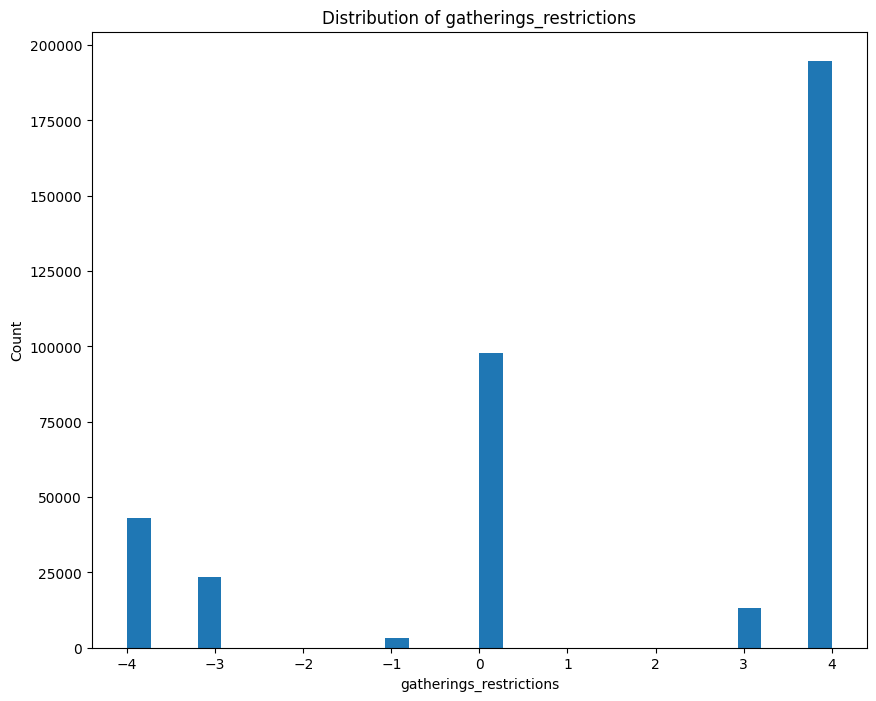

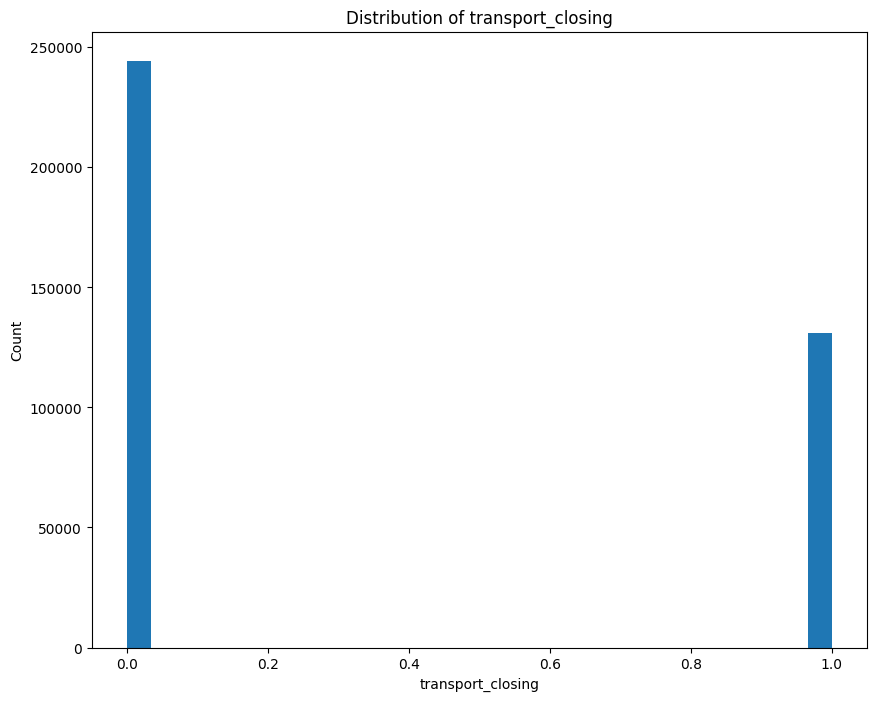

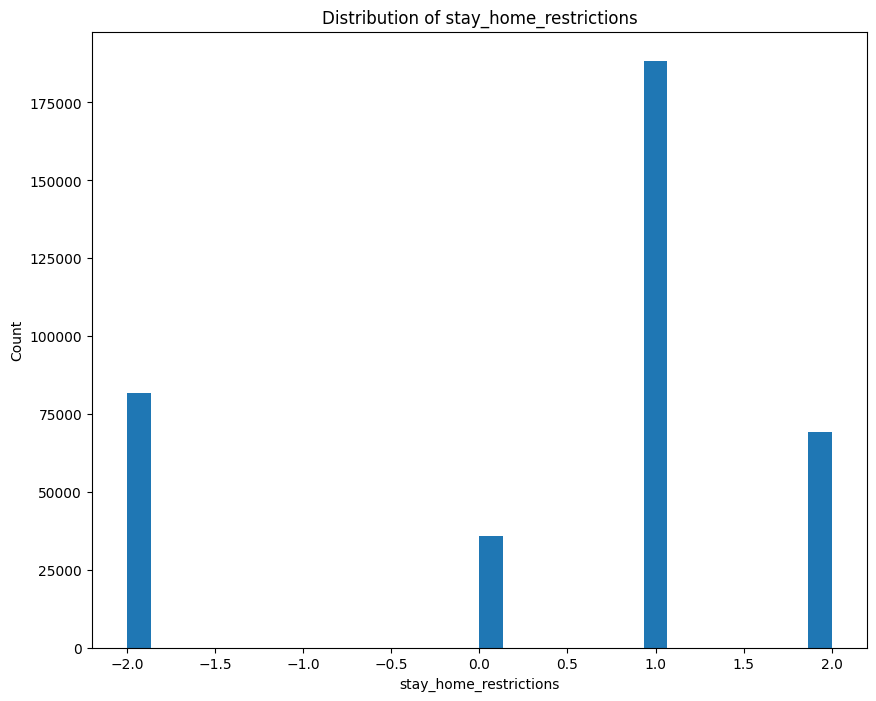

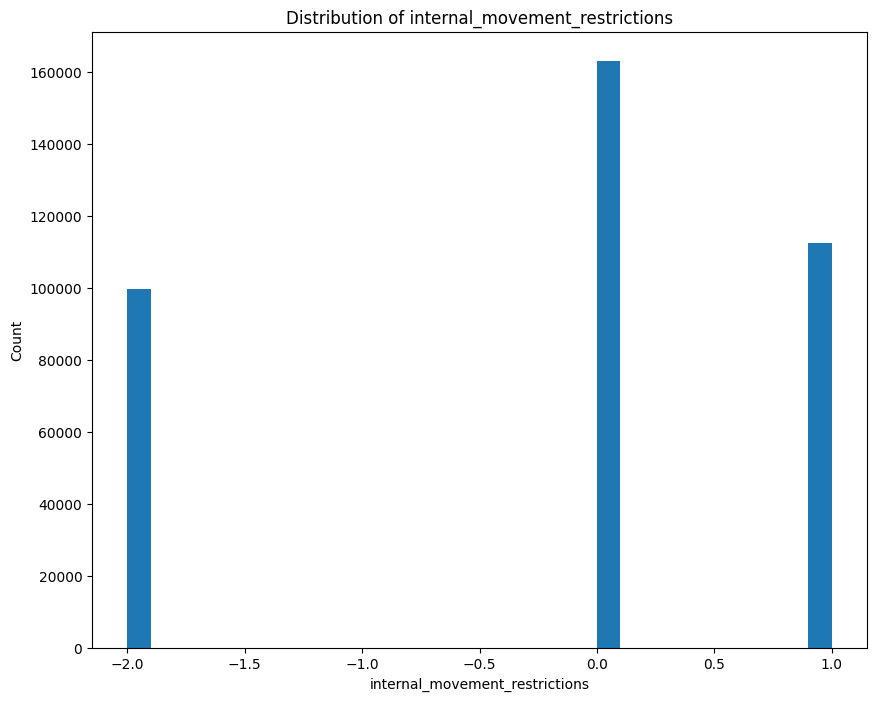

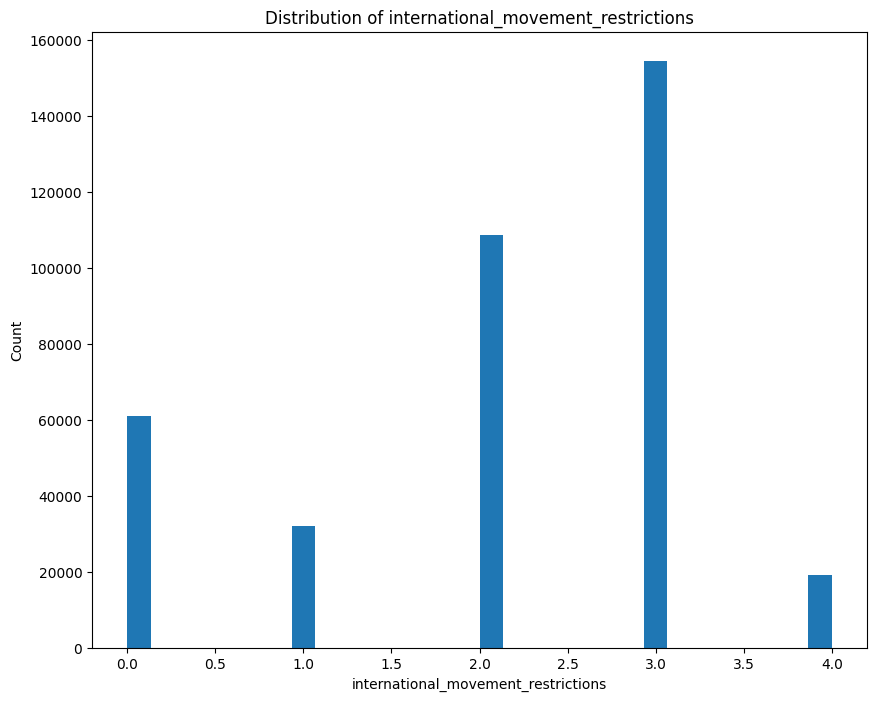

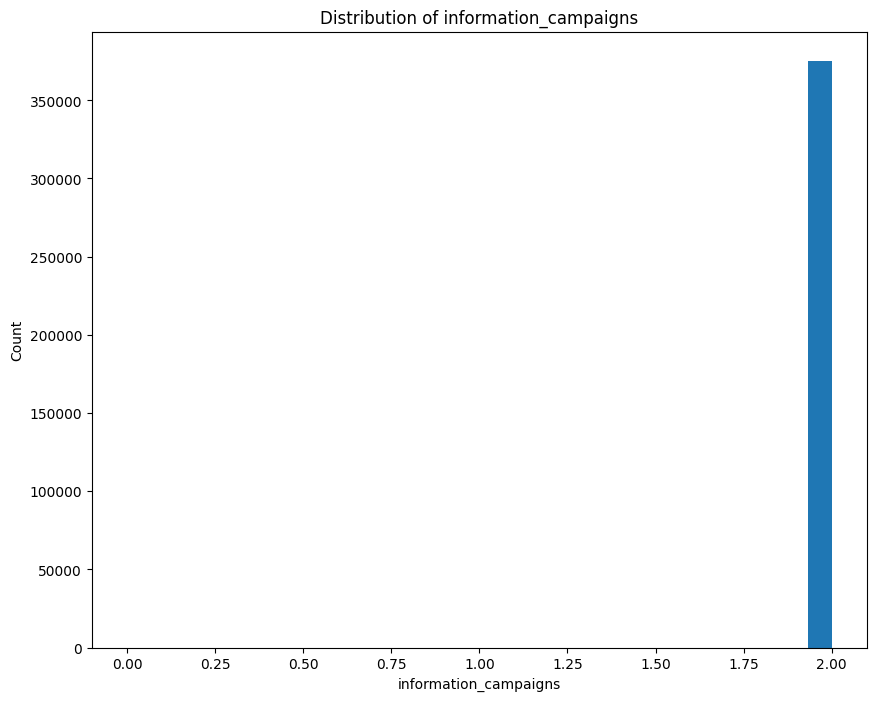

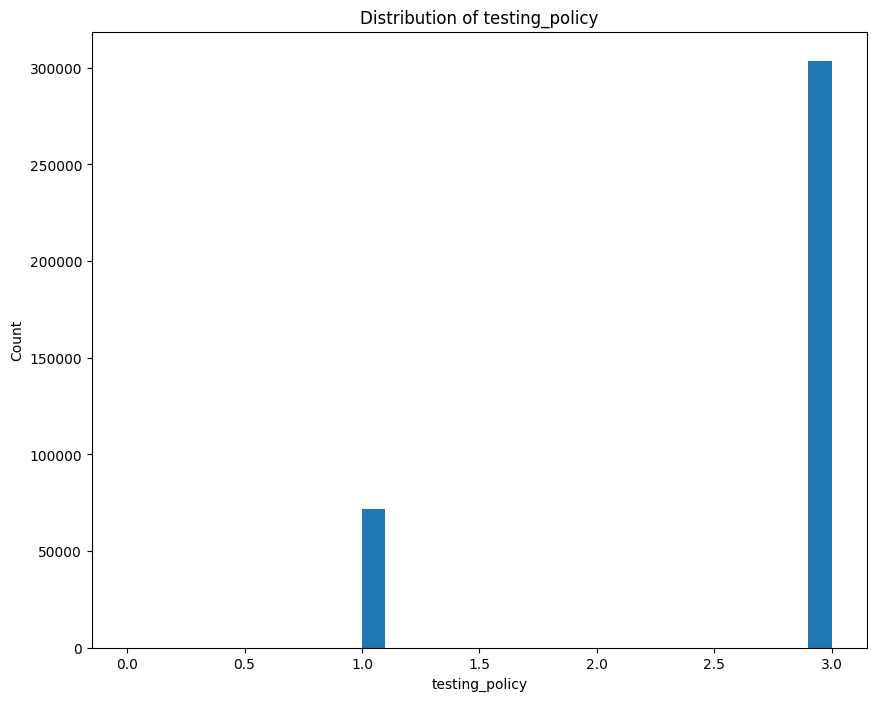

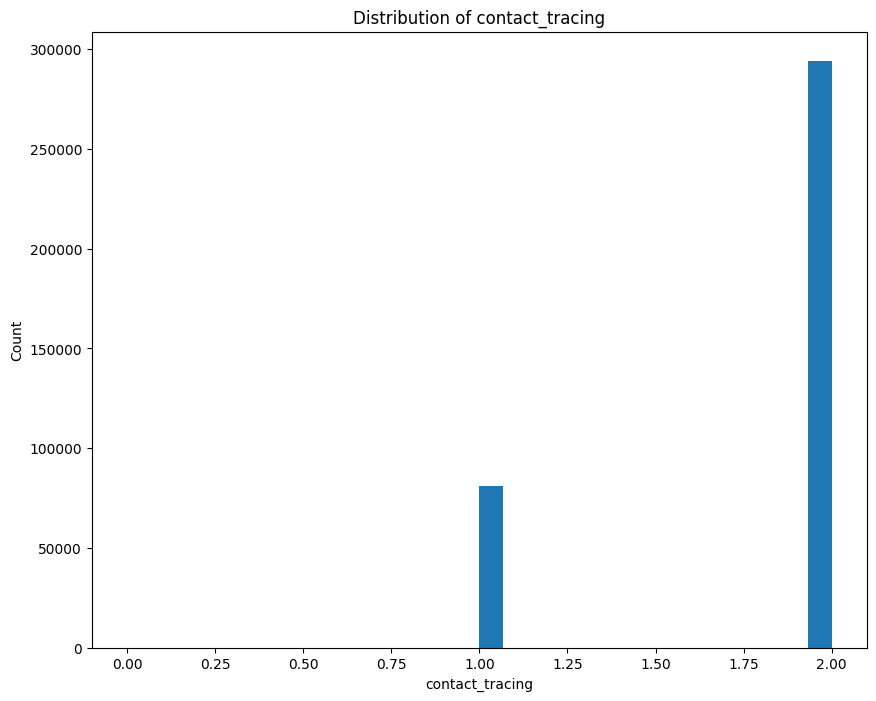

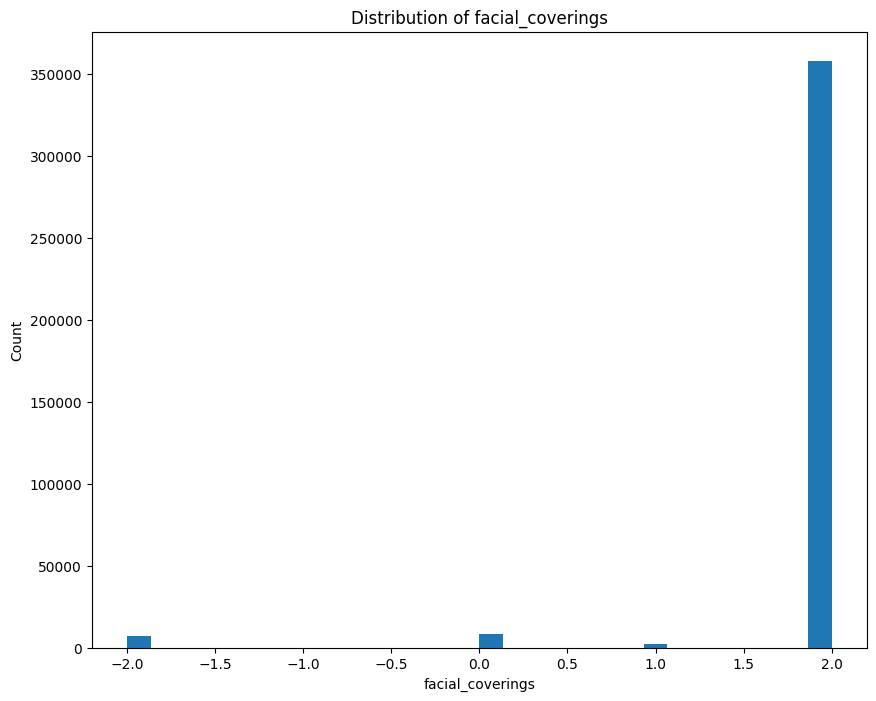

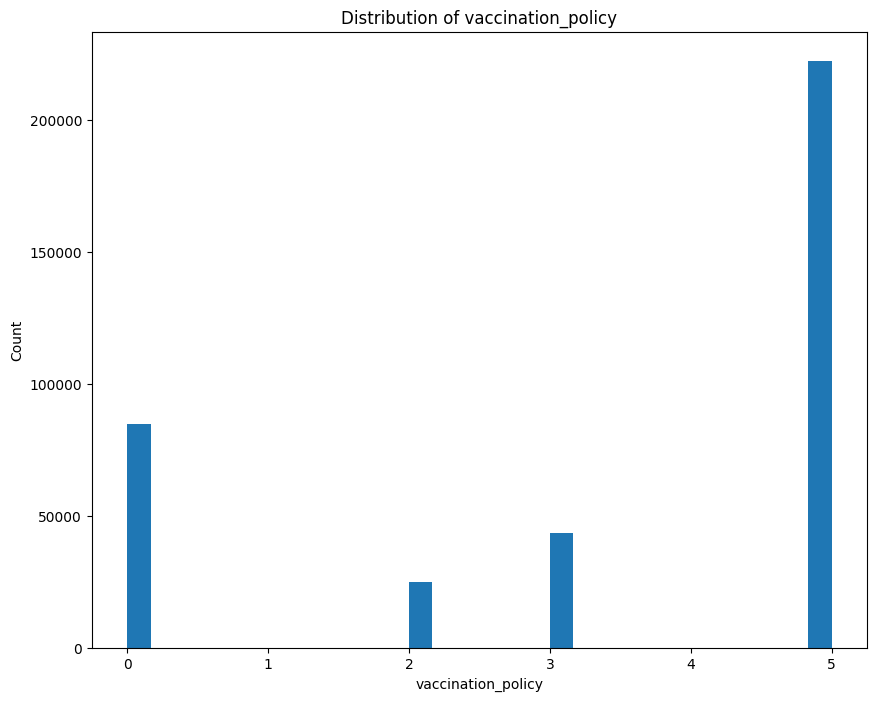

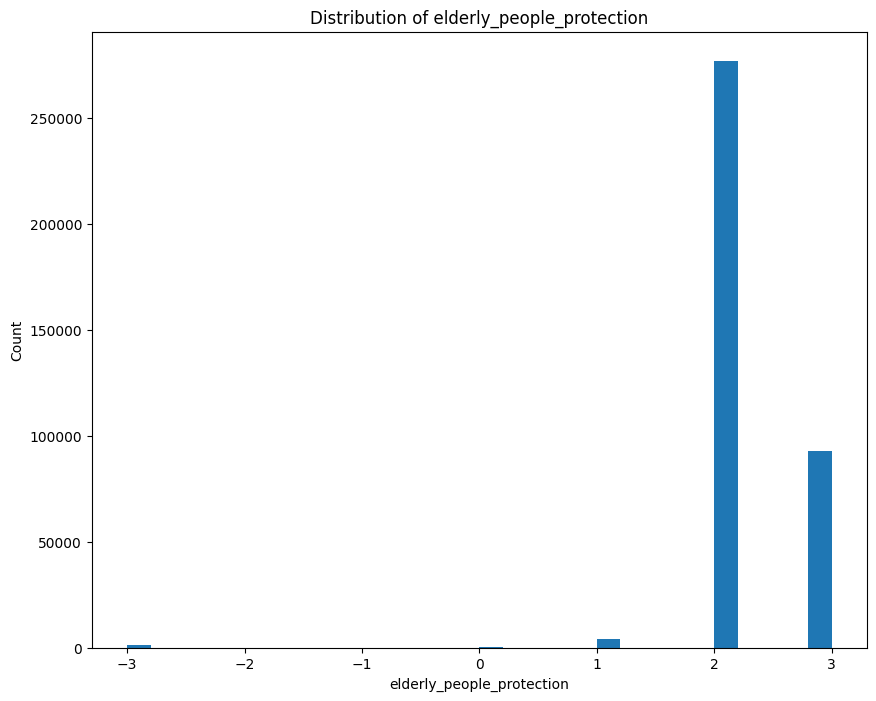

In [ ]:
plot_distribution(processed_df[policy_features])

In [ ]:
plot_distribution(processed_df[epi_features])

## outliers (TODO)
- maybe z-score
- maybe local outlier factor (need to take care of nan values before)

In [ ]:
def z_score(row):
    return (row - row.mean()) / row.std()

In [ ]:
# Apply the function to each row of the dataframe
z_scores = epi_df.apply(z_score, axis=1)

# Print the resulting Z-scores
print(z_scores)

KeyboardInterrupt: ignored

In [ ]:
# Calculate the Z-score for each data point
z_scores = (processed_df['confirmed'] - np.mean(processed_df['confirmed'])) / np.std(processed_df['confirmed'])

# Create a Pandas Series with the Z-scores
z_scores_series = pd.Series(z_scores)

# Find any Z-score that is greater than 3 or less than -3
outliers = z_scores_series[(z_scores_series > 3) | (z_scores_series < -3)]

# Print the outliers, if any
if len(outliers) > 0:
    print("Outliers found:")
    print(outliers)
else:
    print("No outliers found.")

## correlations

In [ ]:
temp = list(epi_features)
temp.append('vaccination_policy')
temp.append('transport_closing')
temp.append('gatherings_restrictions')

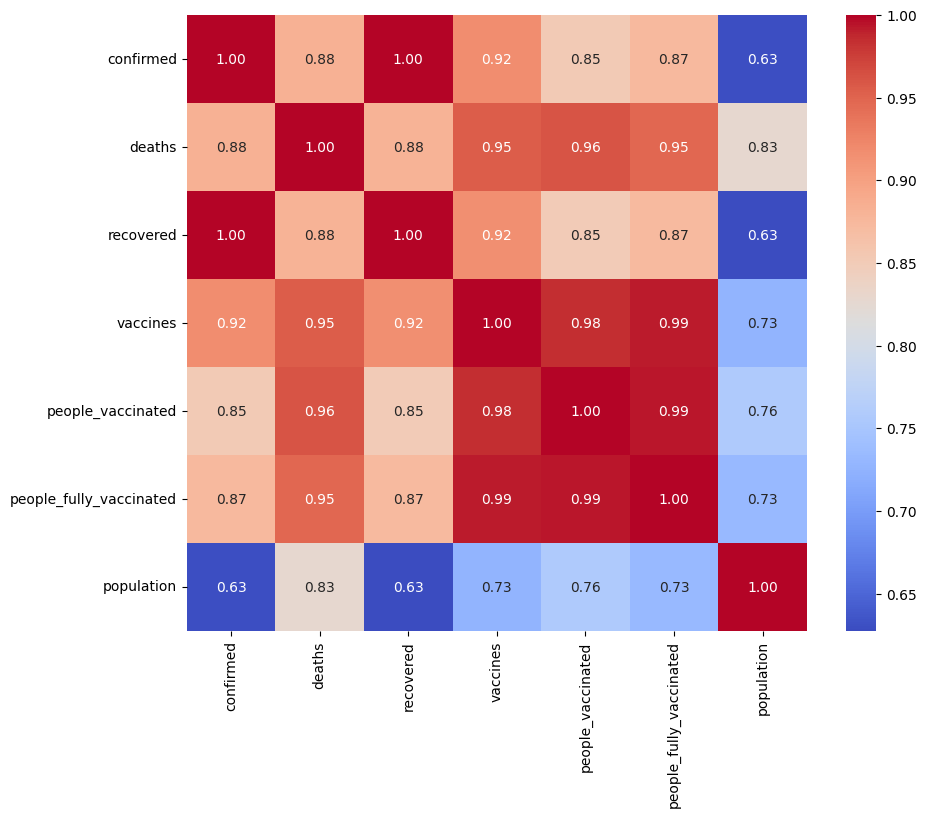

In [ ]:
# Compute correlation matrix
corr_matrix = processed_df[epi_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

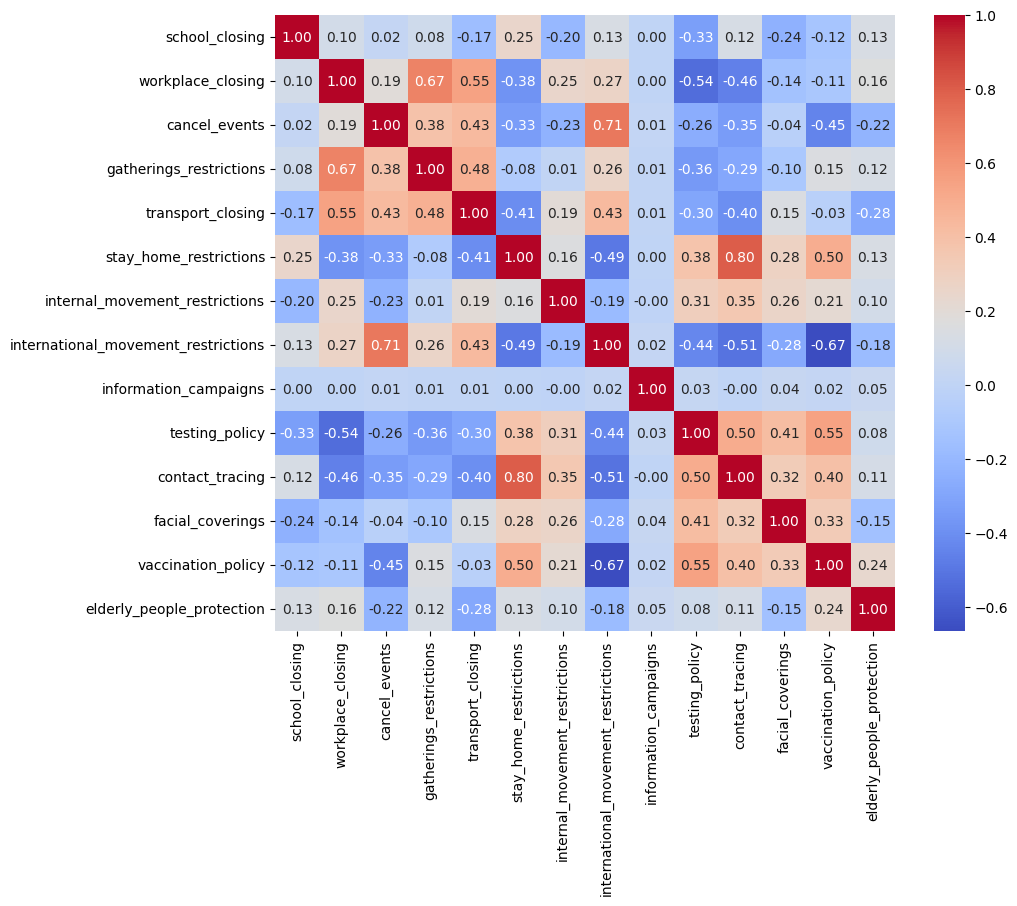

In [ ]:
# Compute correlation matrix
corr_matrix = processed_df[policy_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

## germany map
- https://juanitorduz.github.io/germany_plots/
- [data source](http://www.diva-gis.org/gdata)

In [ ]:
germany = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU_adm/DEU_adm3.shp')

In [ ]:
geo_df = processed_df[['latitude', 'longitude']]
geo_df = geo_df.drop_duplicates(subset=['longitude', 'latitude'])

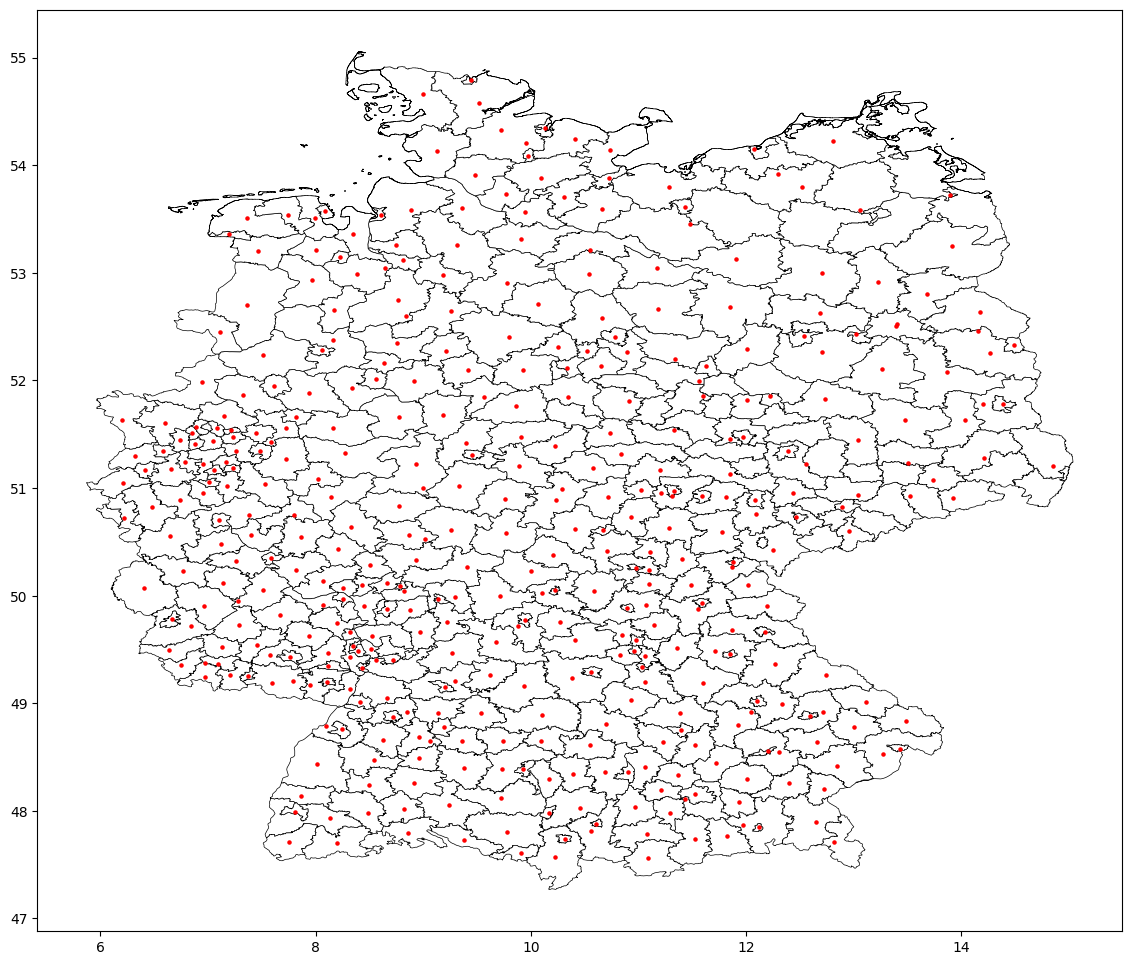

In [ ]:
# plot longitude and latitude on map
fig, ax = plt.subplots(figsize=(14, 18))
geometry = [Point(xy) for xy in zip(geo_df['longitude'], geo_df['latitude'])]
points_gdf = gpd.GeoDataFrame(geometry=geometry)

germany.plot(color='white', edgecolor='black', ax=ax, linewidth=0.5)
# Plot the map of Germany on the figure
points_gdf.plot(color='red', ax=ax, markersize=5)

plt.show()

# time series analysis

### calculating metrics

In [6]:
date_df = to_date_df(processed_df)
kreuzberg_df = get_df_by_district('SK Berlin Friedrichshain-Kreuzberg', date_df)
hamburg_df = get_df_by_district('SK Hamburg', date_df)

In [ ]:
def plot_simple_time_series(df, column_names):
  plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
  plt.plot(df.index, df[column_names])  # Replace 'value' with your actual data column name
  plt.title('Time Series Data')
  plt.xlabel('Date')
  plt.ylabel(column_names)
  plt.grid(True)
  plt.show()

In [ ]:
for i in epi_features:
  plot_simple_time_series(hamburg_df,[i])

In [ ]:
hamburg_row = get_df_row_at_date(hamburg_df, '2021-01-05')
kreuzberg_row = get_df_row_at_date(kreuzberg_df, '2021-01-05')

<ipython-input-100-186eb1aa6cd8>:17: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_date = df.index[df.index.get_loc(target_date, method='nearest')]


In [7]:
def calculate_cfr_metric(df_row):
  # Case Fatality Rate (CFR)
  cfr = df_row['deaths'] / df_row['confirmed']
  return cfr

def calculate_conf_per_popu_metric(df_row):
  return df_row['confirmed'] / df_row['population']

def calculate_incidence(df_row, df):
  #if isinstance(target_date, str):
  #  target_date = pd.to_datetime(target_date)

  # Find the closest date in the index
  # closest_date = df.index[df.index.get_loc(target_date, method='nearest')]

  # Retrieve the row at the closest date index
  #curr_row = df.loc[closest_date]
 
  # Subtract 7 days
  prev_date = df.index[df.index.get_loc(df_row.name - timedelta(days=7), method='nearest')]

  prev_row = df.loc[prev_date]

  newly_infected = df_row['confirmed'] - prev_row['confirmed']

  incidence = (newly_infected/df_row['population']) * 100000

  return incidence

# don't call this
def calculate_incidence_for_whole_df(df_row, df):
  #if isinstance(target_date, str):
  #  target_date = pd.to_datetime(target_date)

  # Find the closest date in the index
  # closest_date = df.index[df.index.get_loc(target_date, method='nearest')]

  # Retrieve the row at the closest date index
  #curr_row = df.loc[closest_date]
 
  # Subtract 7 days
  df = df[df['administrative_area_level_3'] == df_row['administrative_area_level_3']]
  prev_date = df.index[df.index.get_loc(df_row.name - timedelta(days=7), method='nearest')]

  prev_row = df.loc[prev_date]

  newly_infected = df_row['confirmed'] - prev_row['confirmed']

  incidence = (newly_infected/df_row['population']) * 100000

  return incidence


In [8]:
# Apply the function to the DataFrame to calculate the metric for each row
kreuzberg_df['cfr'] = kreuzberg_df.apply(calculate_cfr_metric, axis=1)
date_df['cfr'] = date_df.apply(calculate_cfr_metric, axis=1)
kreuzberg_df['cases_per_population'] = kreuzberg_df.apply(calculate_conf_per_popu_metric, axis=1)
date_df['cases_per_population'] = date_df.apply(calculate_conf_per_popu_metric, axis=1)
kreuzberg_df['incidence'] = kreuzberg_df.apply(calculate_incidence,args=(kreuzberg_df,) , axis=1)
hamburg_df['incidence'] = hamburg_df.apply(calculate_incidence,args=(hamburg_df,) , axis=1)
#date_df['incidence'] = date_df.apply(calculate_incidence,args=(date_df,) , axis=1)

<ipython-input-8-5b0c4cdab141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kreuzberg_df['cfr'] = kreuzberg_df.apply(calculate_cfr_metric, axis=1)
<ipython-input-8-5b0c4cdab141>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kreuzberg_df['cases_per_population'] = kreuzberg_df.apply(calculate_conf_per_popu_metric, axis=1)
<ipython-input-7-0774933a4e0c>:20: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) i

### plotting

In [ ]:
plot_simple_time_series(kreuzberg_df, ['cfr'])

In [ ]:
plot_simple_time_series(kreuzberg_df, ['cases_per_population'])

In [ ]:
plot_simple_time_series(kreuzberg_df, ['incidence'])

In [ ]:
plot_simple_time_series(hamburg_df, ['incidence'])

### trying stuff

In [ ]:
#how to get all policy permutations of a df
#kb_unique_permutations = kreuzberg_df[policy_features].drop_duplicates()

In [9]:
def create_permutation_condition(permutation_row, df):
  filter_cond = True
  #row = test.iloc[0]
  for i in range(len(policy_features)):
    filter_cond &= df[policy_features[i]] == permutation_row[i]

  return filter_cond
  
def filter_df_for_permutation(filter_condition, df):
  return df[filter_condition]

def create_unique_permutation_df_for_district(district_df):
  return district_df[policy_features].drop_duplicates()

In [10]:
def create_permu_df_for_district(district_df):
  # these are all permutations for this district
  #kb_unique_permutations = create_unique_permutation_df_for_district(district_df)
  
  # these are all permutations across Germany (creates NaN values)
  kb_unique_permutations = date_df[policy_features].drop_duplicates()


  kb_unique_permutations['district'] = district_df.iloc[0]['administrative_area_level_3']
  kb_unique_permutations['fed_state'] = district_df.iloc[0]['administrative_area_level_2']
  mean_incidence = []
  #num_of_days = []
  num_of_entries = []
  for i in range(len(kb_unique_permutations)):
    condition_filter = create_permutation_condition(kb_unique_permutations.iloc[i], district_df)
    filtered_df = filter_df_for_permutation(condition_filter, district_df)
    #mean_incidence = filtered_df['incidence'].mean()
    mean_incidence.append(filtered_df['incidence'].mean())
    #num_of_days.append((filtered_df.index[-1] - filtered_df.index[0]).days)
    num_of_entries.append(len(filtered_df))
    #kb_unique_permutations.iloc[i]['mean_incidence'] = mean_incidence

  kb_unique_permutations['mean_incidence'] = mean_incidence
  #kb_unique_permutations['num_of_days'] = num_of_days
  kb_unique_permutations['num_of_entries'] = num_of_entries
  return kb_unique_permutations

In [ ]:
unique_permus = date_df[policy_features].drop_duplicates()

In [ ]:
kb = create_permu_df_for_district(kreuzberg_df)
hb = create_permu_df_for_district(hamburg_df)
# hamburg_df = get_df_by_district('SK Hamburg', date_df)

In [ ]:
combined_df = pd.concat([kb, hb])
print(len(kb))
print(len(hb))
print(len(combined_df))

72
72
144


### future notes
- once i have a df with the incidence for all entries, create a df with all permutations for all districts and calculate the mean incidence for when a permutation of policies was active in this district (i did that already for single districts)
- at that point, we can plot the incidence for every district or federal and start working on an interactive map or something like that
- finding out the "best" permutation is not really possible but we then know which permutation is chosen at what severity (incidence-level). both district wide or nation wide



In [ ]:
# computationally expensive, read the saved df instead of calculating this again
for i in districts:
  district_df = get_df_by_district(i, date_df)
  date_df.loc[date_df['administrative_area_level_3']==i, 'incidence'] = district_df.apply(calculate_incidence,args=(district_df,) , axis=1)

In [33]:
# Save DataFrame as CSV file
# date_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/ai_covid-19/DEU_cleaned_with_incidence.csv')

## TODO
- create table of all permutations and their mean incidence
- then see what happens lol